<!--HEADER-->
[*Guia de aulas da disciplina de Modelagem Matemática*](https://github.com/rmsrosa/modelagem_matematica) *do* [*IM-UFRJ*](https://www.im.ufrj.br).

<!--NAVIGATOR-->

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/20.00-Aula20.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
&nbsp;
<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/20.00-Aula20.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>
&nbsp;
<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/20.00-Aula20.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;

[<- Projeto 4: simulações com EDP](19.01-Projeto4.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Aula 21: Sismologia ->](21.00-Aula21.ipynb)

---


# Aula 20: Retroprojeção não-filtrada

## Objetivos:

- Implementar um algoritmo de cálculo da retroprojeção não-filtrada para a aproximação da transformada inversa de Radon.

- Servir como base para uma implementação da retroprojeção filtrada.

- Servir como base para uma implementação da transformada de Radon a partir de dados discretos (numa malha, como em uma imagem em png lida como um array do numpy).

In [1]:
from os import path

from functools import partial

import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline

import matplotlib.pyplot as plt

import io, base64
from IPython.display import Image, HTML

def path_files_raiosx(filename):
    return path.join('..', 'dados', 'raiosx', filename)

## Transformada de Radon

Na última aula, vimos uma versão da transformada de Radon que lê uma função $f$ e retorna uma outra função, que é a transformada de $f$. A função obtida pode calcular a transformada de Radon em qualquer par $(t,\theta)$ de pontos flutuantes.

In [2]:
def Radon(f):
    '''Versão "contínua" da transformada de Radon
    
    Entrada:
    --------
        f: função python
            Uma função em python, de duas variáveis (x,y) em ponto 
            flutuante, que retorna um valor f(x,y) em ponto flutuante 
            que é interpretado como a densidade de absorção de raio X 
            em cada ponto (x,y).
    Saída:
    ------
        radon_f: função python
            Uma função em python, de duas variáveis (t,theta) em ponto
            flutuante, que dá o valor, no ponto (t, theta), da 
            transformada de Radon da função f 
    '''
    @np.vectorize
    def radon_f(t,theta):
        g = lambda s: f(t*np.cos(theta) - s*np.sin(theta), t*np.sin(theta) + s*np.cos(theta))
        return quad(g, -np.inf, np.inf, epsabs=1.49e-02)[0] 
    return radon_f

help(Radon)

Help on function Radon in module __main__:

Radon(f)
    Versão "contínua" da transformada de Radon
    
    Entrada:
    --------
        f: função python
            Uma função em python, de duas variáveis (x,y) em ponto 
            flutuante, que retorna um valor f(x,y) em ponto flutuante 
            que é interpretado como a densidade de absorção de raio X 
            em cada ponto (x,y).
    Saída:
    ------
        radon_f: função python
            Uma função em python, de duas variáveis (t,theta) em ponto
            flutuante, que dá o valor, no ponto (t, theta), da 
            transformada de Radon da função f



## Sinograma

Também vimos uma outra implementação que retorna, no entanto, um array, com o valor da transformada de Radon já calculado em uma determinada malha, cujos parâmetros também são informados nos argumentos. Batizamos essa função de `sinograma`, por já calcular a transformada numa malha em $[-t_{\rm max}, t_{\rm max}] \times [0, \pi]$.

In [3]:
def sinograma(f, tmax, Nt = 100, Ntheta = 200, Ns = 200):
    '''Retorna o sinograma de uma dada função densidade.
    
    Entradas:
    ---------
        f: função python
            Uma função em python, de duas variáveis (x,y) em ponto 
            flutuante, que retorna um valor f(x,y) em ponto flutuante 
            que é interpretado como a densidade de absorção de raio X 
            em cada ponto (x,y).
        tmax: ponto flutuante
            Um valor positivo, em ponto flutuante, que define o intervalo 
            [-tmax, tmax] no qual a abscissa do sinograma será definida.
        Nt: inteiro
            Um inteiro maior ou igual a 2 indicando o número de pontos 
            da malha uniforme a ser considerada no intervalo em t, 
            com t_0 = - tmax e t_{Nt-1} = tmax.
        Ntheta: inteiro
            Um inteiro maior ou igual a 2 indicando o número de pontos 
            da malha uniforme a ser considerada no intervalo [0, pi] 
            em theta, com theta_0 = 0 e theta_{Ntheta-1} = pi.
        Ns: inteiro
            Um inteiro maior ou igual a 2 indicando o número de pontos 
            no intervalo [-smax, smax], com smax = tmax, s_0 = -smax, 
            s_{Ns-1} = smax, usado para calcular uma soma de Riemann
            aproximando a integral em s envolvida na definição da 
            transformada de Radon em cada ponto (t_i, theta_j) 
            do sinograma. 
    Saída:
    ------
        sino: numpy array 
            Um array do numpy de dimensões Ntheta e Nt representando 
            o sinograma nos pontos (t_i, theta_j) da malha no retângulo 
            [-tmax, tmax] x [0, pi]. Observe que, na notação matricial 
            usada para esse numpy array, o primeiro índice indica a linha 
            e está associada à ordenada theta, enquanto que o segundo 
            índice está associado à abscissa t, contrariamente à ordem 
            t x theta da função sinograma.
            
    '''
    t = np.linspace(-tmax, tmax, Nt)
    theta = np.linspace(0, np.pi, Ntheta)
    smax = tmax
    sinterval, ds = np.linspace(-smax, smax, Ns, retstep=True)
    T, Theta = np.meshgrid(t, theta)
    sino = sum([f(T*np.cos(Theta) - s*np.sin(Theta), T*np.sin(Theta) + s*np.cos(Theta))*ds for s in sinterval])
    return sino

help(sinograma)

Help on function sinograma in module __main__:

sinograma(f, tmax, Nt=100, Ntheta=200, Ns=200)
    Retorna o sinograma de uma dada função densidade.
    
    Entradas:
    ---------
        f: função python
            Uma função em python, de duas variáveis (x,y) em ponto 
            flutuante, que retorna um valor f(x,y) em ponto flutuante 
            que é interpretado como a densidade de absorção de raio X 
            em cada ponto (x,y).
        tmax: ponto flutuante
            Um valor positivo, em ponto flutuante, que define o intervalo 
            [-tmax, tmax] no qual a abscissa do sinograma será definida.
        Nt: inteiro
            Um inteiro maior ou igual a 2 indicando o número de pontos 
            da malha uniforme a ser considerada no intervalo em t, 
            com t_0 = - tmax e t_{Nt-1} = tmax.
        Ntheta: inteiro
            Um inteiro maior ou igual a 2 indicando o número de pontos 
            da malha uniforme a ser considerada no intervalo [0, pi]

## Exemplo: função densidade com quadrados concêntricos

Retornemos ao exemplo de uma função densidade associada a quadrados concêntricos.

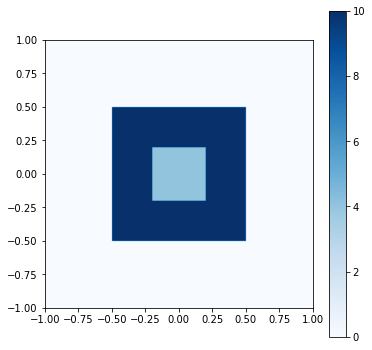

In [4]:
@np.vectorize
def f_quadrados(x,y):
    return np.where(max(x**2,y**2) < 0.25, 10, 0) - np.where(max(x**2,y**2) < 0.04, 6, 0)

xmax = 1.0
ymax = 1.0

x =  np.linspace(-xmax, xmax, 200)
y = np.linspace(-ymax, ymax, 200)

X, Y = np.meshgrid(x,y)
Z = f_quadrados(X,Y)

plt.figure(figsize=(6,6))
im = plt.imshow(Z, interpolation='bilinear', cmap=plt.cm.Blues,
               origin='lower', extent=[-xmax, xmax, -ymax, ymax],
               vmin=Z.min(), vmax=Z.max())
plt.colorbar(im)
plt.show()

## Tempos de cálculo do sinograma

Usando a forma "discreta", que nos dá um array com sinograma completo, o tempo de execução não é tão demorado. 

No caso de uma malha em $(t,\theta)$ de 100 x 200 pontos (default da função), temos

In [5]:
%%time
tmax = np.sqrt(xmax**2 + ymax**2)
f_quadrados_sinograma = sinograma(f_quadrados, tmax)

CPU times: user 23.1 s, sys: 191 ms, total: 23.2 s
Wall time: 23.6 s


Já o sinograma nessa mesma malha mas obtido através da versão "contínua" da transformada de Radon nos dá um tempo da ordem de 8 minutos.

Esse cálculo pode ser feito com um bloco da forma
```(bash)
%%time
hc = Radon(f_quadrados)
Tc, Thetac = np.meshgrid(np.linspace(-tmax, tmax, 100), np.linspace(0, np.pi, 200))
hc(Tc, Thetac)
```

com o resultado
```(bash)
CPU times: user 7min 56s, sys: 857 ms, total: 7min 57s
Wall time: 7min 58s
``` 

## Visualização do sinograma

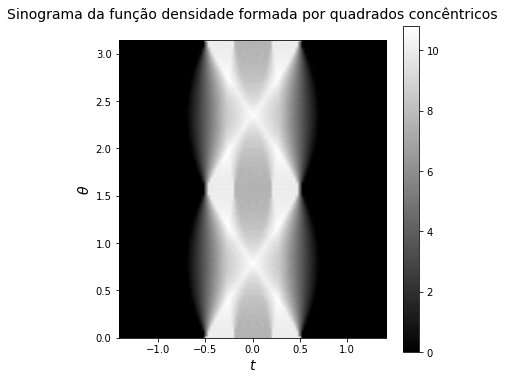

In [6]:
plt.figure(figsize=(6,6))
im = plt.imshow(f_quadrados_sinograma, interpolation='bilinear', cmap=plt.cm.gray,
               origin='lower', extent=[-tmax, tmax, 0.0, np.pi],
               vmin=f_quadrados_sinograma.min(), vmax=f_quadrados_sinograma.max())
plt.xlabel(r'$t$', fontsize=14)
plt.ylabel(r'$\theta$', fontsize=14)
plt.title('Sinograma da função densidade formada por quadrados concêntricos\n', fontsize=14)
plt.colorbar(im)
plt.show()

### Retroprojeção

Para a retroprojeção não-filtrada, precisamos calcular

$$ (\mathcal{R}^*h)(x,y) = \frac{1}{\pi}\int_0^\pi h(x\cos\theta + y\sin\theta, \theta) \;\rm d \theta.
$$

assumindo-se $h = \mathcal{R}f$ conhecida. Em princípio, isso poderia ser feito com algum método de quadratura para aproximar a integral.

No entanto, na prática, não conhecemos $h$ em todos os pontos $(t,\theta)$. Só a conhecemos em um determinada malha $(t_i, \theta_j)_{ij}$. 

Por conta disso, é necessário fazer interpolações para estimar o valor de $h$ em pontos $(x\cos\theta + y\sin\theta, \theta)$ fora dessa malha.

Um facilitador é que a segunda coordenada é o próprio $\theta$. Então podemos implementar uma quadratura usando explicitamente esses pontos, de modo que só precisamos nos preocupar em interpolar a função $h$ em relação à primeira coordenada.

Além disso, $t = x\cos\theta + y\sin\theta$ traça um gráfico suave em relação à $\theta$, o que também pode ser explorado para acelerar a interpolação.

### Interpolação

Da mesma forma, buscamos encontrar a retroprojeção $\mathcal{R}^*h$ apenas em uma certa malha $(x_n, y_m)$.

Assim, para cada ponto $(x_n, y_m)$, precisamos percorrer os ângulos $\theta_j$ e encontrar, para cada $j$, o índice $i_j$ tais que os instantes $t_{i_j}$ e $t_{i_j+1}$ satisfaçam

$$ t_{i_j} \leq x_n\cos\theta_j + y_m\sin\theta_j < t_{i_j+1}.
$$

Em seguida, aproximamos a integral

$$ (\mathcal{R}^*h)(x,y) = \frac{1}{\pi}\int_0^\pi h(x\cos\theta + y\sin\theta, \theta) \;{\rm d} \theta
$$

por uma soma de Riemann com a partição $\theta_j$, interpolando cada ponto $x_n\cos\theta_j + y_m\sin\theta_j$ entre pontos $t_{i_j}$ e $t_{i_j+1}$ apropriados.

O trabalho computacional maior, então, é encontrar os índices $i_j$ de maneira eficiente.

### Visualizando o caminho senoidal sobre da malha

Lembremos que o caminho $t=x\cos\theta + y\sin\theta$ é uma senoide com 

$$t|_{\theta=0}= x \quad t|_{\theta=\pi/2} = y, \quad t|_{\theta=\pi} = -x.
$$

Para visualizar melhor a necessidade da interpolação, vamos exibir esse caminho junto com a malha e usando uma malha bastante grossa.

In [8]:
xmax = ymax = 1.0
N = 16
xn = ym = np.linspace(-xmax, xmax, N)

tmax = np.sqrt(xmax**2 + ymax**2)

ti = np.linspace(-tmax, tmax, N)
thetaj = np.linspace(0.0, np.pi, N)

Nt = 100
Ntheta = 200
t, dt = np.linspace(-tmax, tmax, Nt, retstep=True)
theta, dtheta = np.linspace(0, np.pi, Ntheta, retstep=True)

Ti, Thetaj = np.meshgrid(ti, thetaj)

xp = xn[2]
yp = ym[7]
t_theta = xp*np.cos(theta) + yp*np.sin(theta)
print(f'Caminho associado ao ponto (x,y) = ({xp:.2f}, {yp:.2f})')

Caminho associado ao ponto (x,y) = (-0.73, -0.07)


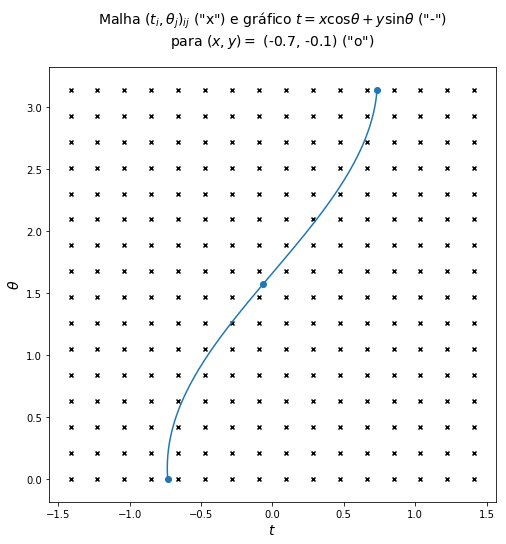

In [9]:
plt.figure(figsize=(8,8))

plt.plot(t_theta, theta, color="tab:blue")
plt.scatter(Ti, Thetaj, marker='x', color="black", s=16)

plt.scatter([xp, yp, -xp], [0.0, np.pi/2, np.pi], color="tab:blue")

plt.xlabel(r"$t$", fontsize=14)
plt.ylabel(r"$\theta$", fontsize=14)

plt.title(r'Malha $(t_i, \theta_j)_{ij}$ ("x") e gráfico $t=x\cos\theta + y\sin\theta$ ("-")' 
          + f'\npara $(x, y) = $ ({xp:.1f}, {yp:.1f}) ("o")\n', fontsize=14)
plt.show()

### Visualizando vários caminhos

In [10]:
nlist = [0, 1, 5, 7, 12, 15, 0]
mlist = [0, 3, 7, 9, 2, 15, 15]

t_theta_list = [xn[nlist[l]]*np.cos(theta) + ym[mlist[l]]*np.sin(theta) for l in range(len(nlist))]

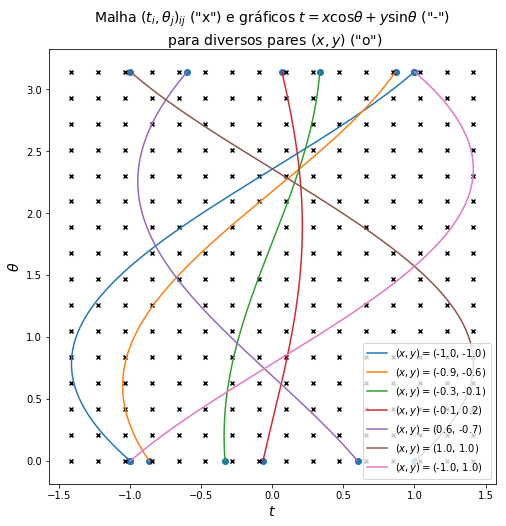

In [11]:
plt.figure(figsize=(8,8))

for l in range(len(nlist)):
    labeltext = r"$(x, y) = $"+f"({xn[nlist[l]]:.1f}, {ym[mlist[l]]:.1f})"
    plt.plot(t_theta_list[l], theta, label=labeltext)
    plt.scatter([xn[nlist[l]], -xn[nlist[l]]], [0.0, np.pi], color="tab:blue")
    
plt.scatter(Ti, Thetaj, marker='x', color="black", s=16)

plt.xlabel(r"$t$", fontsize=14)
plt.ylabel(r"$\theta$", fontsize=14)
plt.legend()
plt.title(r'Malha $(t_i, \theta_j)_{ij}$ ("x") e gráficos $t=x\cos\theta + y\sin\theta$ ("-")'
          + f'\n para diversos pares $(x,y)$ ("o")', fontsize=14)
plt.show()

### Pontos fora da malha

Definindo $\alpha$ como o sendo o ângulo tal que

$$ \cos\alpha = \frac{x}{\sqrt{x^2 + y^2}}, \qquad \sin\alpha = \frac{y}{\sqrt{x^2 + y^2}},
$$

podemos reescrever o caminho $t=x\cos\theta + y\sin\theta$ na forma

$$ \sqrt{x^2 + y^2}\left(\cos\alpha\cos\theta_j + \sin\alpha\sin\theta_j\right) = \sqrt{x^2 + y^2}\cos(\theta_j - \alpha),
$$ 

que é uma senoide com amplitude $\sqrt{x^2 + y^2}$ e fase $\alpha$.

Um aspecto importante disso é que é fácil ver que o caminho está restrito ao intervalo $[-\sqrt{x^2 + y^2}, \sqrt{x^2 + y^2}]$, portanto, restrito ao domínio do sinograma.

Portanto, se estamos querendo reproduzir a função original em uma malha $(x,y)$ no retângulo

$$ [-x_{\rm max}, x_{\rm max}] \times [-y_{\rm max}, y_{rm max}],
$$

então o sinograma precisa estar definido em uma malha $(t,x)$ no retângulo

$$ [-t_{\rm max}, t_{\rm max}] \times [0, \pi],
$$

onde 

$$ t_{\rm max} = \sqrt{x_{\rm max}^2 + y_{\rm max}^2}.
$$

Caso contrário, teremos alguns caminhos que extrapolam o domínio $t\theta$ em que a malha está definida.

### Extrapolação

No caso em que há caminhos que extrapolam a malha no domínio $t\theta$, vamos supor que o objeto está contido na região $xy$ original e que a imagem dessa região pela transformada de Radon está contida na região coberta pela malha, então a transformada de Radon do objeto se anula fora da malha.

Nos pontos fora da malha, ao invés de encontrarmos $t_{i_j}$ com 

$$ t_{i_j} \leq x_n\cos\theta_j + y_m\sin\theta_j < t_{i_j+1}.
$$

temos 

$$ x_n\cos\theta_j + y_m\sin\theta_j < t_0
$$

ou 

$$ t_I \leq x_n\cos\theta_j + y_m\sin\theta_j,
$$

onde $t_I$ é o último ponto da malha $(t_i)_i$.

### Limite de interpolação

Mesmo assumindo que $t_{\rm max} = \sqrt{x_{\rm max}^2 + y_{\rm max}^2}$ e que a função densidade se anula fora de $[-x_{\rm max}, x_{\rm max}]\times [-y_{\rm max}, y_{\rm max}]$, pode acontecer, de, para um determinado par $(x_n, y_m)$ a fase $\alpha$ associada a esse par coincida com um ângulo $\theta_j$ da malha angular. 

Nesse caso, teremos $t_{i_j} = t_{\rm max}$ e o índice posterior $t_{i_j}$ estaria fora da malha.

Isso pode ser evitado considerando $t_{\rm max}> \sqrt{x_{\rm max}^2 + y_{\rm max}^2}$ ou aumentando a malha em um mais um ponto, além de $t_{\rm max}$, ou, ainda, fazendo uma extrapolação conforme mencionao acima.

### Interpolação

Podemos encontrar os índices $i_j$ usando a função `numpy.where`, como feito a seguir.

Observe que fazemos uma concatenação com o array `[-1]`, para o caso da curva extrapolar para valores abaixo de $-t_{\rm max}$.

In [12]:
xp = xn[2]
yp = ym[7]
t_theta = xp*np.cos(theta) + yp*np.sin(theta)
t_thetaj = xp*np.cos(thetaj) + yp*np.sin(thetaj)

indices = np.array([np.concatenate([np.array([-1]), np.where(ti <= t_thetaj[j])[0]])[-1] for j in range(len(thetaj))])
indices = np.array([np.where(ti <= t_thetaj[j])[0][-1] for j in range(len(t_thetaj))])

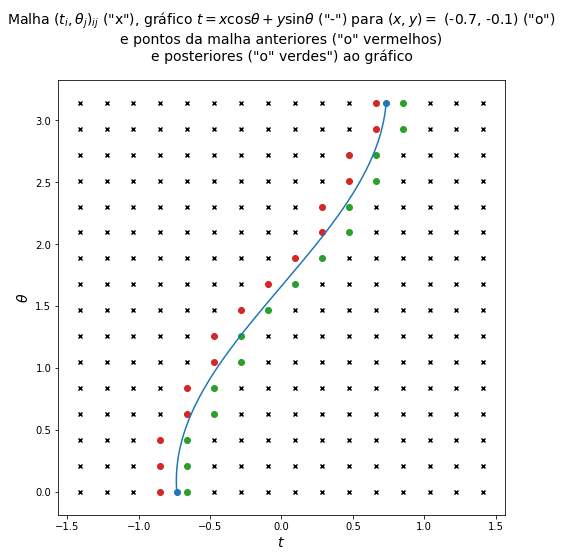

In [13]:
plt.figure(figsize=(8,8))

plt.plot(t_theta, theta, color="tab:blue")
plt.scatter(Ti, Thetaj, marker='x', color="black", s=16)
plt.scatter([xp, -xp], [0.0, np.pi], color="tab:blue")
plt.scatter(ti[indices], thetaj, marker='o', color="tab:red")
plt.scatter(ti[indices+1], thetaj, marker='o', color="tab:green")

plt.xlabel(r"$t$", fontsize=14)
plt.ylabel(r"$\theta$", fontsize=14)
plt.title(r'Malha $(t_i, \theta_j)_{ij}$ ("x"), gráfico $t=x\cos\theta + y\sin\theta$ ("-")' 
          + f' para $(x, y) = $ ({xp:.1f}, {yp:.1f}) ("o")'
          + f'\ne pontos da malha anteriores ("o" vermelhos)\ne posteriores ("o" verdes")'
          + f' ao gráfico\n', fontsize=14)
plt.show()

## Estendendo a malha 

A próxima curva ilustra a necessidade de aumentar a malha no eixo $t$, para registrar os pontos posteriores para determinados valores de $\theta_j$.

Poderíamos fazer uma extrapolação assumindo que a transformada de Radon se anula folha da malha, mas parece ser mais eficiente estender a malha do que checar, em cada ponto, se é necessário fazer uma interpolação ou uma extrapolação.

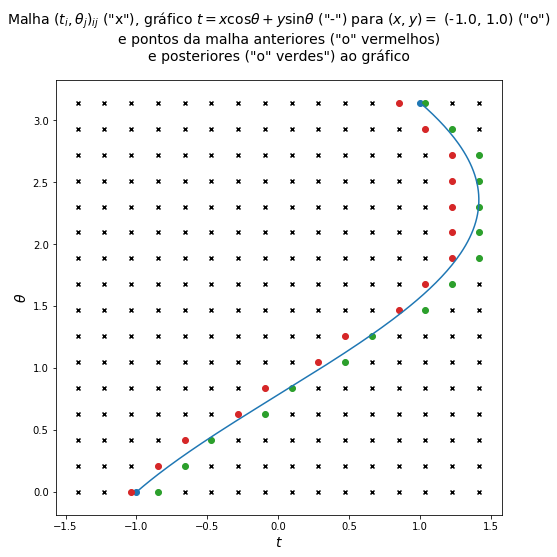

In [14]:
xp = xn[0]
yp = ym[15]
t_theta = xp*np.cos(theta) + yp*np.sin(theta)
t_thetaj = xp*np.cos(thetaj) + yp*np.sin(thetaj)

indices = np.array([np.concatenate([np.array([-1]), np.where(ti <= t_thetaj[j])[0]])[-1] for j in range(len(t_thetaj))])

plt.figure(figsize=(8,8))

plt.plot(t_theta, theta, color="tab:blue")
plt.scatter(Ti, Thetaj, marker='x', color="black", s=16)
plt.scatter([xp, -xp], [0.0, np.pi], color="tab:blue")
plt.scatter(ti[indices], thetaj, marker='o', color="tab:red")
plt.scatter(ti[indices+1], thetaj, marker='o', color="tab:green")

plt.xlabel(r"$t$", fontsize=14)
plt.ylabel(r"$\theta$", fontsize=14)
plt.title(r'Malha $(t_i, \theta_j)_{ij}$ ("x"), gráfico $t=x\cos\theta + y\sin\theta$ ("-")' 
          + f' para $(x, y) = $ ({xp:.1f}, {yp:.1f}) ("o")'
          + f'\ne pontos da malha anteriores ("o" vermelhos)\ne posteriores ("o" verdes")'
          + f' ao gráfico\n', fontsize=14)
plt.show()

### Tempo de cálculo dos pontos de interpolação

Podemos calcular o tempo típico gasto para se encontrar os pontos de interpolação com a função `%timeit`. Para isso, vamos usar a malha mais fina.

In [15]:
T, Theta = np.meshgrid(t, theta)

%timeit np.array([np.where(t <= t[j])[0][-1] for j in range(len(t))])
%timeit np.array([np.concatenate([np.array([-1]), np.where(t <= t[j])[0]])[-1] for j in range(len(t))])

351 µs ± 44.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
703 µs ± 161 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Aproximando a integral 

Agora que já sabemos os pontos em relação aos quais devemos interpolar a função $h$, podemos aproximar a integral desejada. 

Quebramos a integral no intervalo $[0, \pi]$ em subintervalos $[\theta_j, \theta_{j+1})$:

$$ \frac{1}{\pi} \int_0^\pi h(x\cos\theta + y\sin\theta, \theta) \;{\rm d} \theta = \frac{1}{\pi}\sum_j \int_{\theta_j}^{\theta_{j+1}} h(x\cos\theta + y\sin\theta, \theta) \;{\rm d} \theta
$$


Em cada subintervalo, usamos uma regra do trapézio e aproximamos a integral por 

$$\frac{1}{2}\left(h(x\cos\theta_j + y\sin\theta_j, \theta_j) + h(x\cos\theta_{j+1} + y\sin\theta_{j+1}, \theta_j)\right) \Delta \theta
$$

Por sua vez, cada $h(x\cos\theta_j + y\sin\theta_j, \theta_j)$ é aproximado linearmente entre os pontos da malha imediatamente anteriores $t_{i_j}$ e posteriores $t_{i_j+1}$ ao ponto $t(\theta_j) = x\cos\theta_j + y\sin\theta_j$ da curva senoidal:

$$ h(t(\theta_j), \theta_j) \approx \frac{(t_{i_j+1} - t(\theta_j))h(t_{i_j}, \theta_j) + (t(\theta_j) - t_{i_j})h(t_{i_j+1}, \theta_j)}{t_{i_j+1} - t_{i_j}}
$$


### Caminho de integração

Observe que cada integral

$$ \int_{\theta_j}^{\theta_{j+1}} h(x\cos\theta + y\sin\theta, \theta) \;{\rm d} \theta
$$

não é uma integral de linha de $h(t,\theta)$ sobre um caminho ligando os pontos

$$ (x\cos\theta_j + y\sin\theta_j, \theta_j) \quad \text{e} \quad (x\cos\theta_{j+1} + y\sin\theta_{j+1}, \theta_{j+1})
$$

mas apenas uma integral unidimensional no intervalo $[\theta_j, \theta_{j+1})$ da função composta 

$$ \theta \mapsto h(x\cos\theta + y\sin\theta, \theta)
$$



### Calculando a aproximação

In [16]:
%%time
h = sinograma(f_quadrados, tmax)

CPU times: user 24.1 s, sys: 243 ms, total: 24.3 s
Wall time: 25.6 s


In [17]:
%%time
indices = np.array([np.concatenate([np.array([-1]), np.where(t <= t_theta[j])[0]])[-1] for j in range(len(t_theta))])

hpre = np.array([h[j, indices[j]] if indices[j] >=0 else 0 for j in range(len(theta))])
hpos = np.array([h[j, indices[j]+1] if indices[j] < h.shape[1] else 0 for j in range(len(theta))])
haprox = ((t[indices+1] - t_theta)*hpre + (t_theta - t[indices])*hpos)/dt
hintegral = np.sum((haprox[1:] + haprox[:-1])/2)/np.pi

CPU times: user 4.41 ms, sys: 1.33 ms, total: 5.74 ms
Wall time: 6.97 ms


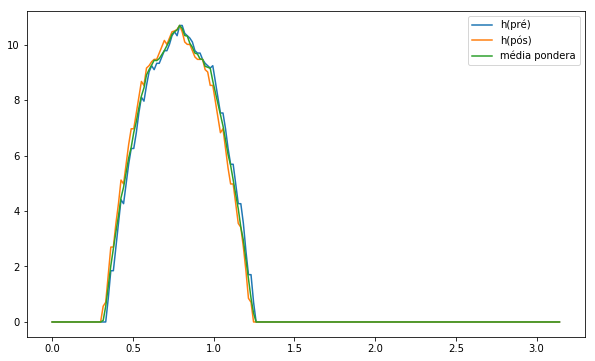

In [18]:
plt.figure(figsize=(10,6))

plt.plot(theta, hpre, label="h(pré)")
plt.plot(theta, hpos, label="h(pós)")
plt.plot(theta, haprox, label="média pondera")

plt.legend()
plt.show()

## Ampliando detalhe

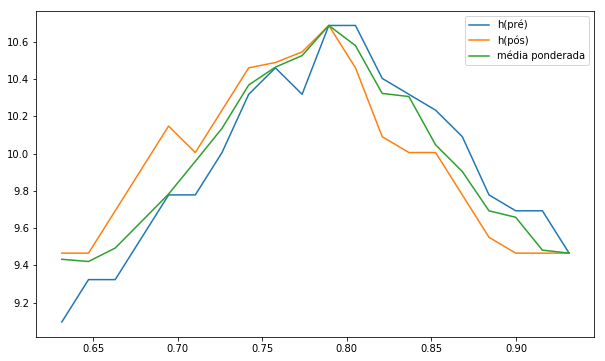

In [19]:
plt.figure(figsize=(10,6))

plt.plot(theta[40:60], hpre[40:60], label="h(pré)")
plt.plot(theta[40:60], hpos[40:60], label="h(pós)")
plt.plot(theta[40:60], haprox[40:60], label="média ponderada")

plt.legend()
plt.show()

## Função de retroprojeção pontual

In [20]:
def retroprojecao_pontual(h, t, theta, xp, yp):

    dt = t[1]-t[0]  # assumindo malha uniforme em t
    dtheta = theta[1] - theta[0] # assumindo malha uniforme em theta
    
    t_theta = xp*np.cos(theta) + yp*np.sin(theta) # caminho senoidal

    jrange = range(len(theta))

    indices = np.array([np.where(t <= t_theta[j])[0][-1] for j in jrange])

#    hpre = [h[j, indices[j]] for j in jrange]
#    hpos = [h[j, indices[j]+1] for j in jrange]

    hpre = np.array([h[j, indices[j]] if indices[j] >= 0 else 0 for j in jrange])
    hpos = np.array([h[j, indices[j]+1] if indices[j] < h.shape[1] else 0 for j in jrange])
    
    haprox = ((t[indices+1] - t_theta)*hpre + (t_theta - t[indices])*hpos)/dt
    
    hintegral = np.sum((haprox[1:] + haprox[:-1]))*dtheta/np.pi/2
    
    return hintegral

In [23]:
print(f'Retroprojeção no ponto (x,y) = {retroprojecao_pontual(h, t, theta, xn[2], ym[7]):.2f}')

Retroprojeção no ponto (x,y) = 4.20


In [22]:
%timeit retroprojecao_pontual(h, t, theta, xn[2], ym[7])

1.09 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Retroprojeção

Uma forma simples de implementar a retroprojeção da imagem completa é usar uma [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions):

```(python)
h_retro = [[retroprojecao_pontual(h, t, theta, xx, yy) 
                                    for xx in x] for yy in y]
```

Tempo de execução:

In [24]:
%%time 
h_retro = [[retroprojecao_pontual(h, t, theta, xx, yy) for xx in x] for yy in y]

CPU times: user 41.6 s, sys: 367 ms, total: 42 s
Wall time: 43.7 s


## Visualizando a retroprojeção não-filtrada

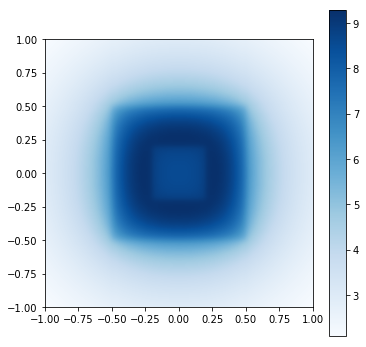

In [25]:
plt.figure(figsize=(6,6))
Z = np.array(h_retro)
im = plt.imshow(Z, interpolation='bilinear', cmap=plt.cm.Blues,
               origin='lower', extent=[-xmax, xmax, -ymax, ymax],
               vmin=Z.min(), vmax=Z.max())
plt.colorbar(im)
plt.show()

## Acelerando a retroprojeção

Podemos acelerar a retroprojeção pontual e, com isso, a global, usando o `np.where` em uma versão matricial e calculando `hpre` e `hpos` de forma vetorial, no `numpy`, como feito a seguir.

In [26]:
def retroprojecao_pontual_2(xp, yp, h, t, theta):

    dt = t[1]-t[0]  # assumindo malha uniforme em t
    dtheta = theta[1] - theta[0] # assumindo malha uniforme em theta
    
    t_theta = xp*np.cos(theta) + yp*np.sin(theta) # caminho senoidal
    
    T, T_theta = np.meshgrid(t, t_theta)    
    I = np.meshgrid(range(len(t)), theta)[0]
    
    jrange = range(len(theta))

    i_pre = np.where(T<=T_theta, I, 0).max(axis=1)   

    hpre = h[jrange, i_pre]
    hpos = h[jrange, i_pre + 1]
    
    haprox = ((t[i_pre+1] - t_theta)*hpre + (t_theta - t[i_pre])*hpos)/dt
    
    hintegral = np.sum((haprox[1:] + haprox[:-1]))*dtheta/np.pi/2
    
    return hintegral

In [27]:
print(r'Retroprojeção no ponto (x,y) = ' + f'{retroprojecao_pontual_2(xn[2], ym[7], h, t, theta):.2f}')

Retroprojeção no ponto (x,y) = 4.20


Observe a melhoria (1/3) no tempo de execução da retroprojecao pontual:

In [28]:
%timeit retroprojecao_pontual_2(xn[2], ym[7], h, t, theta)

357 µs ± 22.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Essa melhoria é refletida na retroprojecao global:

In [30]:
%%time 
h_retro = [[retroprojecao_pontual_2(xx, yy, h, t, theta) for xx in x] for yy in y]

CPU times: user 15.5 s, sys: 320 ms, total: 15.8 s
Wall time: 16.8 s


## Vetorizando para acelerar um pouco mais

Podemos acelerar a retroprojeção global um pouco mais, vetorizando a retroprojeção pontual e aplicando-a direto à malha gerada por `x` e `y`, além de pré-definir alguns parâmetros que não mudam a cada cálculo.

Para isso, criamos uma nova função de retroprojeção pontual que recebe diversos parâmetros já calculados e usamos o método `partial` do módulo padrão `functools` para fixar esses parâmetros, antes de vetorizar a função no numpy.

In [31]:
def retroprojecao_pontual_3(xp, yp, h, t, theta, dt, dtheta, I, jrange):

    t_theta = xp*np.cos(theta) + yp*np.sin(theta) # caminho senoidal
    T, T_theta = np.meshgrid(t, t_theta)
    i_pre = np.where(T<=T_theta, I, 0).max(axis=1) 

    hpre = h[jrange, i_pre]
    hpos = h[jrange, i_pre + 1]
    haprox = ((t[i_pre+1] - t_theta)*hpre + (t_theta - t[i_pre])*hpos)/dt
    hintegral = np.sum((haprox[1:] + haprox[:-1]))*dtheta/np.pi/2

    return hintegral

retroprojecao_pontual_vetorizada = np.vectorize(partial(retroprojecao_pontual_3, 
                                            h=h, t=t, theta=theta, 
                                            dt=t[1]-t[0], dtheta=theta[1]-theta[0],
                                            I=np.meshgrid(range(len(t)), theta)[0],
                                            jrange=range(len(theta))))

In [32]:
X, Y = np.meshgrid(x,y)

Observe agora a ligeira melhoria no cálculo da retroprojeção global:

In [33]:
%%time 
h_retro = retroprojecao_pontual_vetorizada(X,Y)

CPU times: user 10.9 s, sys: 239 ms, total: 11.2 s
Wall time: 11.4 s


## Visualizando para conferir o resultado

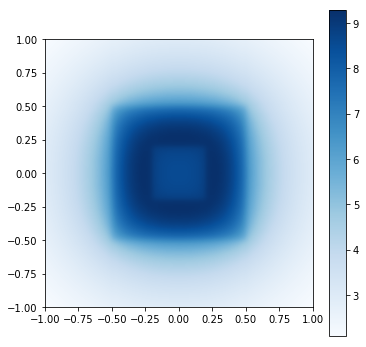

In [34]:
plt.figure(figsize=(6,6))
im = plt.imshow(h_retro, interpolation='bilinear', cmap=plt.cm.Blues,
               origin='lower', extent=[-xmax, xmax, -ymax, ymax],
               vmin=h_retro.min(), vmax=h_retro.max())
plt.colorbar(im)
plt.show()

---

### Apresentação em slides

In [36]:
!jupyter nbconvert 20.00-Aula20.ipynb --to slides --SlidesExporter.reveal_scroll=True --template output_toggle.tpl

[NbConvertApp] Converting notebook 20.00-Aula20.ipynb to slides
[NbConvertApp] Writing 828190 bytes to 20.00-Aula20.slides.html


<!--NAVIGATOR-->

---
[<- Projeto 4: simulações com EDP](19.01-Projeto4.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Aula 21: Sismologia ->](21.00-Aula21.ipynb)

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/20.00-Aula20.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/20.00-Aula20.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>

<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/20.00-Aula20.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;